This notebook will be an exploratory analysis of the Global Terrorism Dataset using Time Series Clustering
Goal is to transform the data into a usable time-series dataset, and employ a variety of muliti-variate time-series clustering  
techniques in order to learn about the similarities between countries and their respective terrorism problems. 

In [34]:
%pwd
%cd C:\Users\james\OneDrive\Documents\Machine Learning\Terrorism

C:\Users\james\OneDrive\Documents\Machine Learning\Terrorism


The GTD defines a terrorist attack as the threatened or actual use of illegal force 
and violence by a non-state actor to attain a political, economic, religious, or social 
goal through fear, coercion, or intimidation

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [39]:
df = pd.read_excel('globalterrorismdb_0919dist.xlsx')
df1993 = pd.read_excel('globalterrorismdb_93dist.xlsx')

In [40]:
df = pd.concat([df, df1993])

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192212 entries, 0 to 747
Columns: 135 entries, eventid to related
dtypes: datetime64[ns](1), float64(54), int64(23), object(57)
memory usage: 199.4+ MB


First challenge will be to see which parts of the dataset are worth keeping - 135 is a lot of columns,  
and the goal of this exploration will be to find groups of similar countries.  
Most interested in frequency, type of attacks, and type of targets. Ideally would also look at 'types of perpetrators', but due to the unconstrained nature of the 'gname' field,  
will probably just leave it out as not bothered to build a robust way of labelling each group. 

In [42]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


First will try to visualise the data  


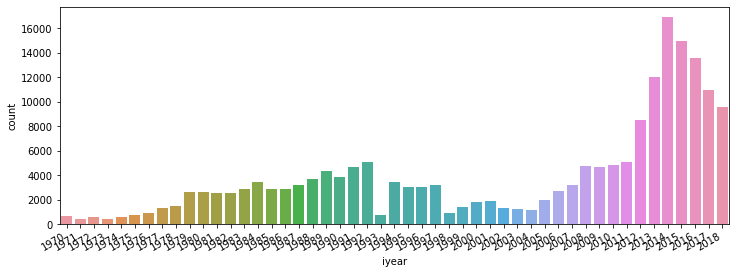

In [43]:
fig, ax = plt.subplots(figsize = (12,4))

a = sns.countplot(df['iyear'], ax = ax)
ax.set_xticklabels(a.get_xticklabels(), rotation = 30, ha = 'right');

So terrorist attacks were largely static until around 2010 when they shot up
Lets have a look by region

In [44]:
df.region_txt.unique()

array(['Central America & Caribbean', 'North America', 'Southeast Asia',
       'Western Europe', 'East Asia', 'South America', 'Eastern Europe',
       'Sub-Saharan Africa', 'Middle East & North Africa',
       'Australasia & Oceania', 'South Asia', 'Central Asia'],
      dtype=object)

In [45]:
df.region_txt.value_counts()

Middle East & North Africa     53319
South Asia                     48326
Sub-Saharan Africa             19807
South America                  19377
Western Europe                 17065
Southeast Asia                 13408
Central America & Caribbean    10369
Eastern Europe                  5229
North America                   3616
East Asia                        816
Central Asia                     574
Australasia & Oceania            306
Name: region_txt, dtype: int64

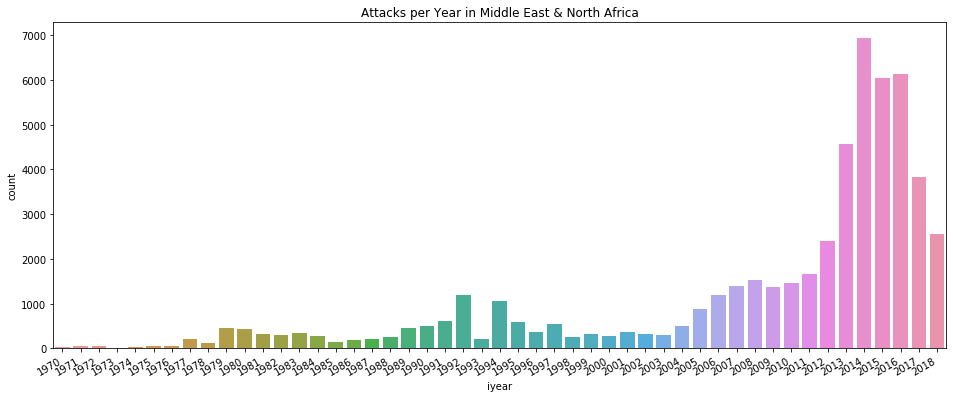

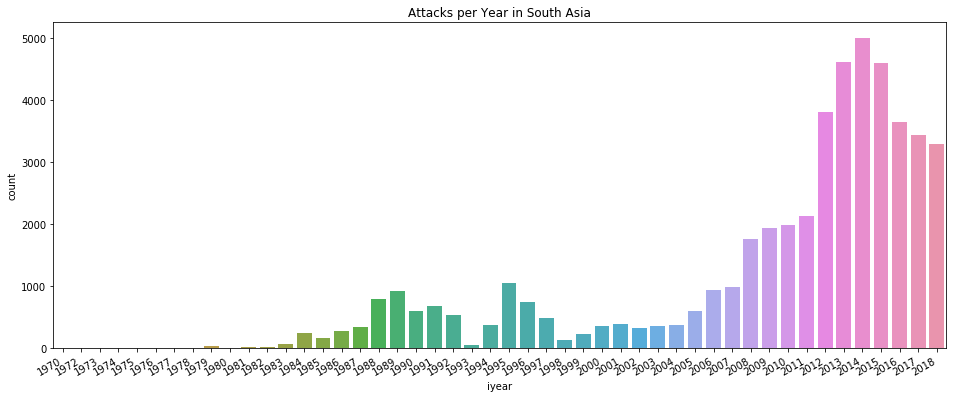

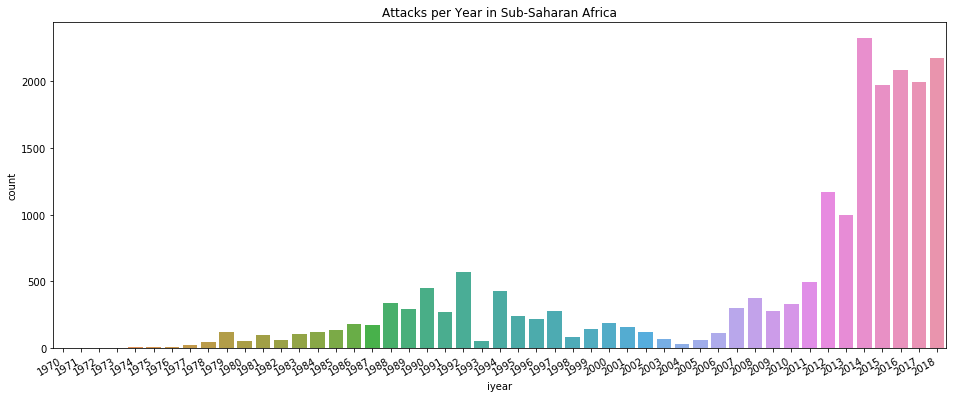

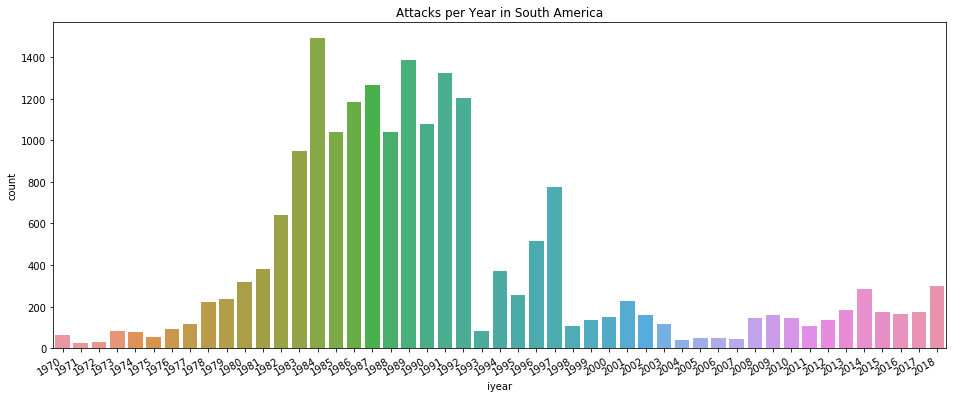

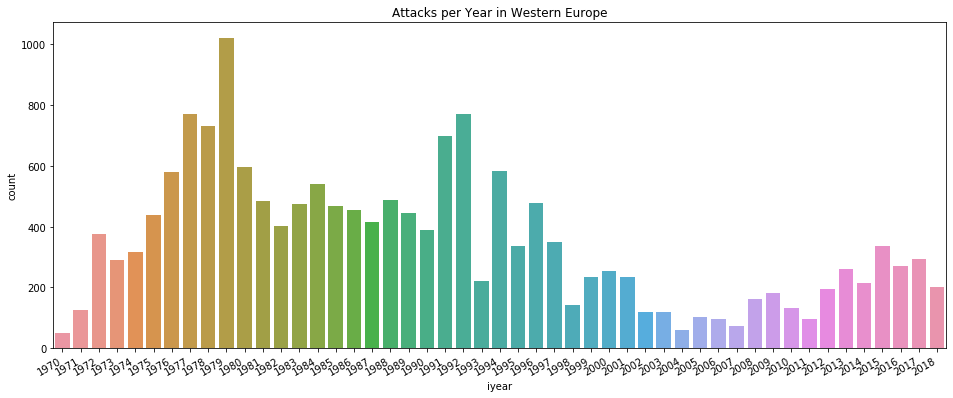

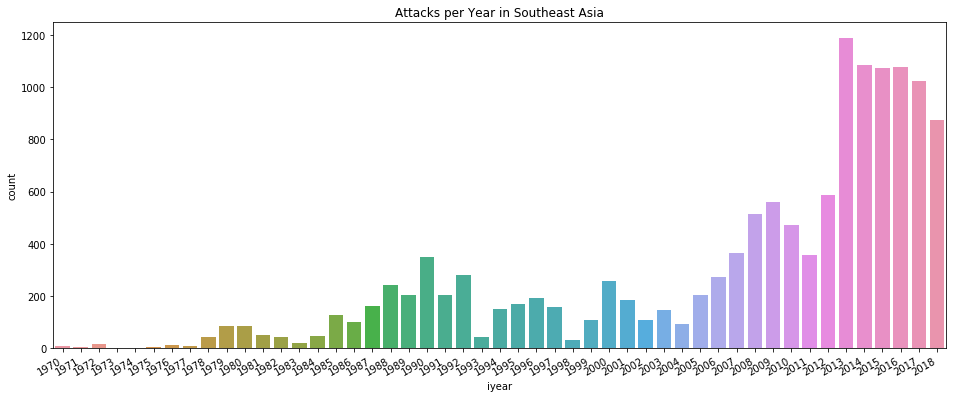

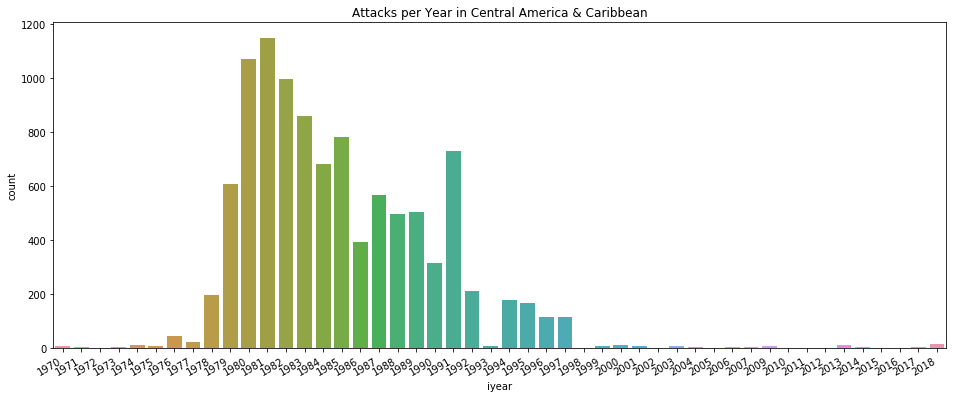

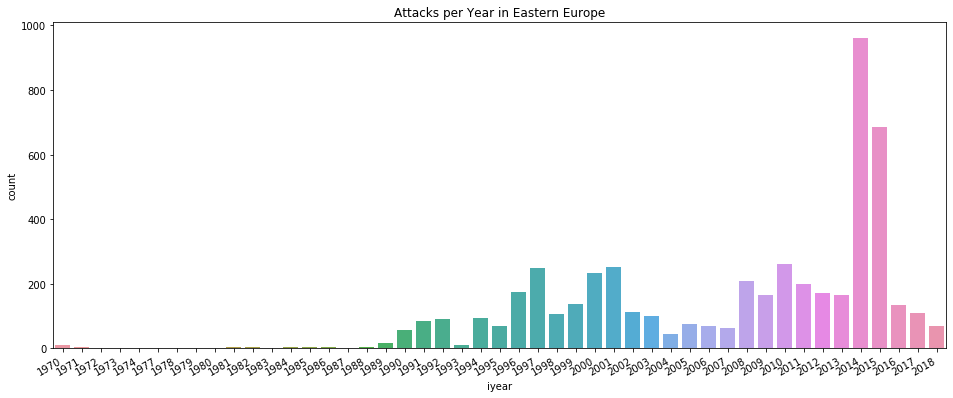

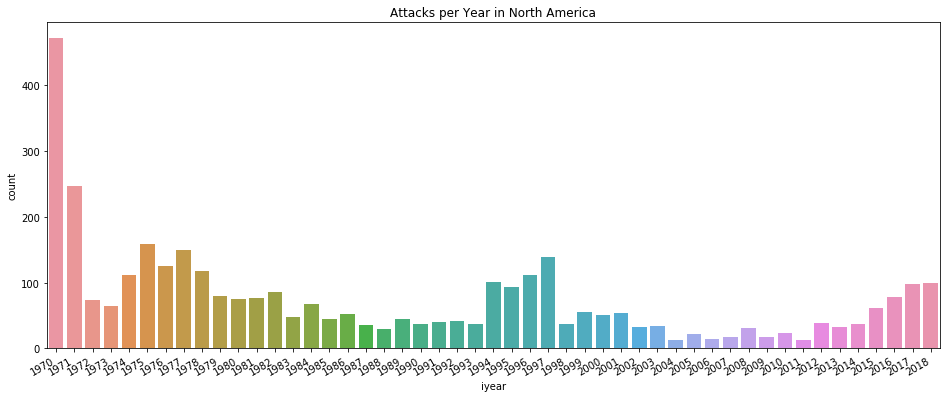

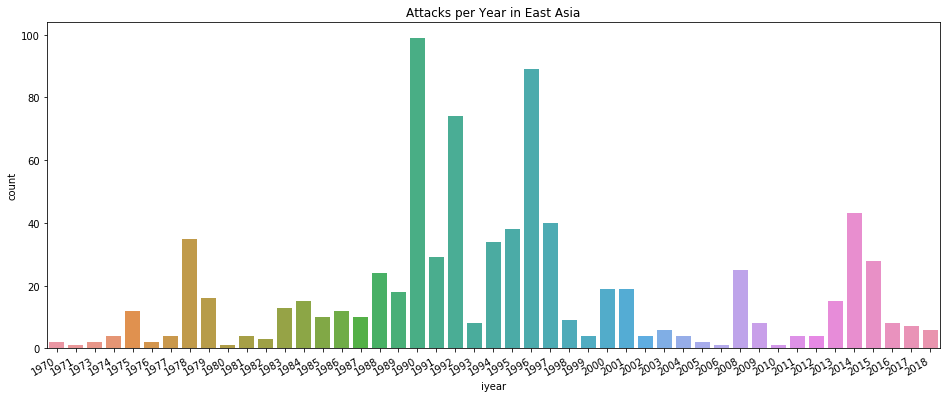

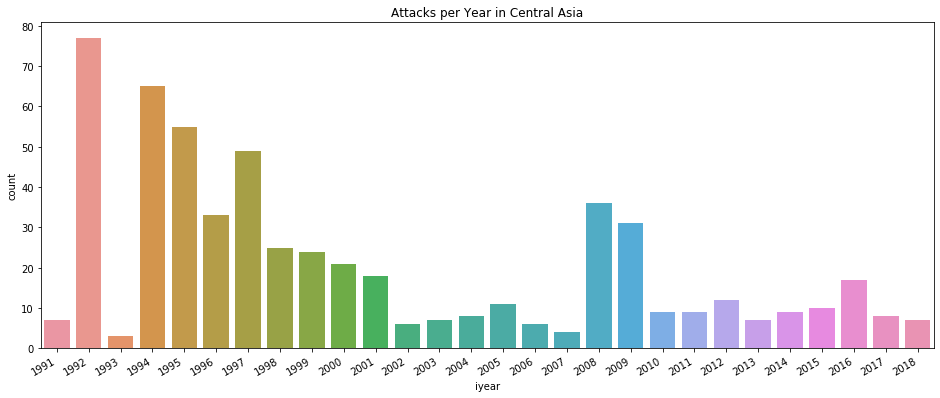

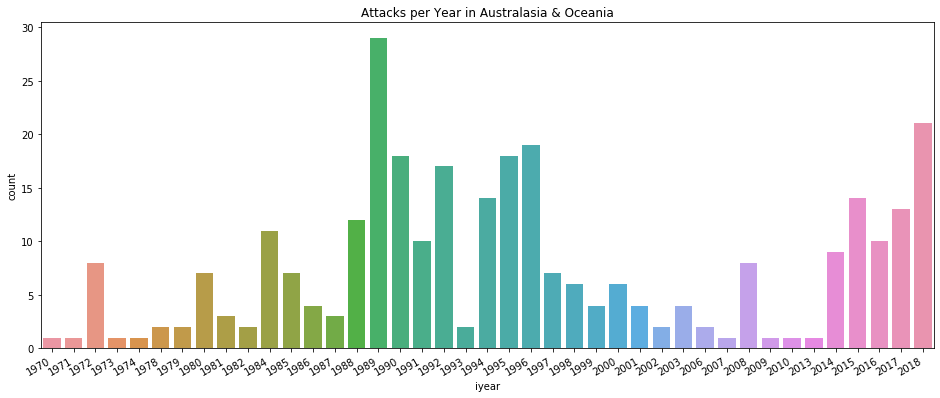

In [46]:

for i, region in enumerate(df.region_txt.value_counts().index):
    
    plt.figure(i, figsize = (16,6))
    a = sns.countplot(df.loc[df.region_txt == region,'iyear'])
    a.set_xticklabels(a.get_xticklabels(), rotation = 30, ha = 'right')
    a.set_title('Attacks per Year in {}'.format(region))






Next to explore is type of attacks by region, and their targets

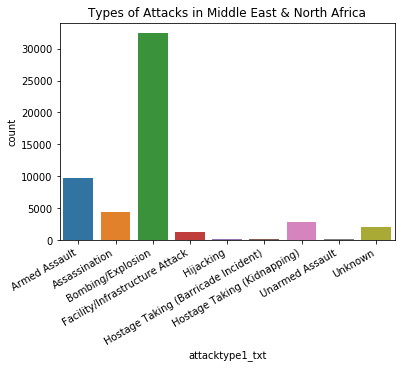

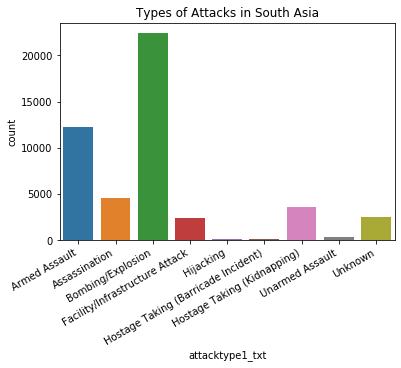

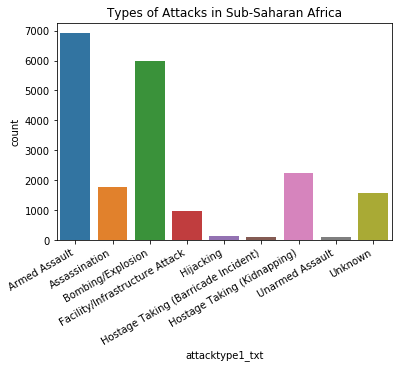

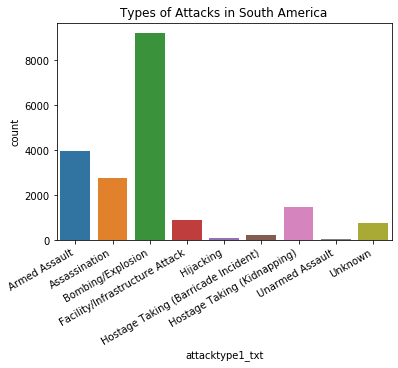

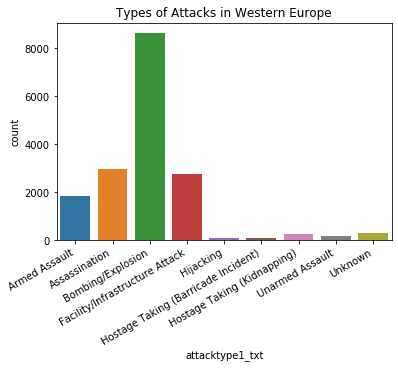

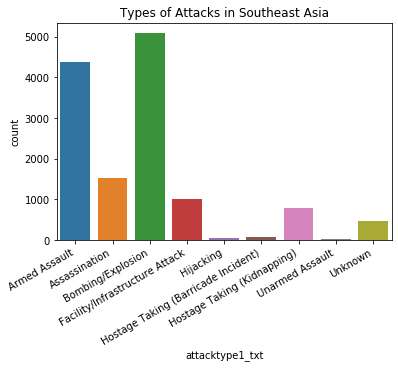

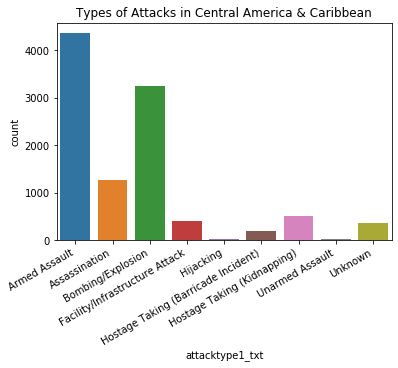

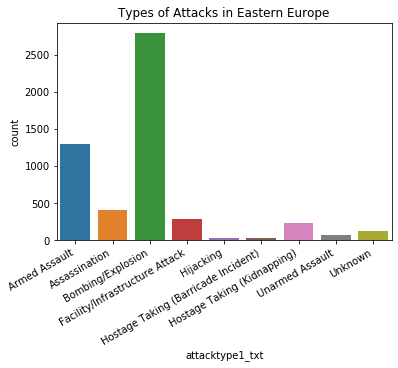

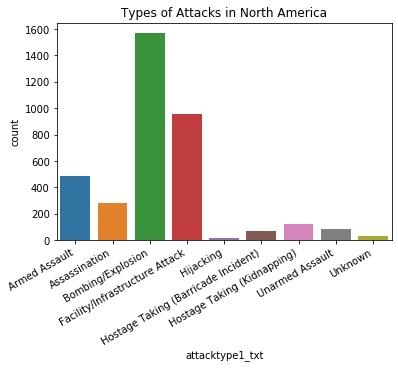

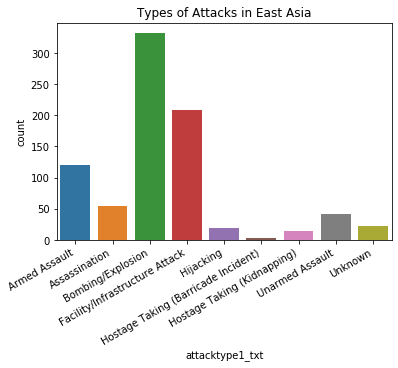

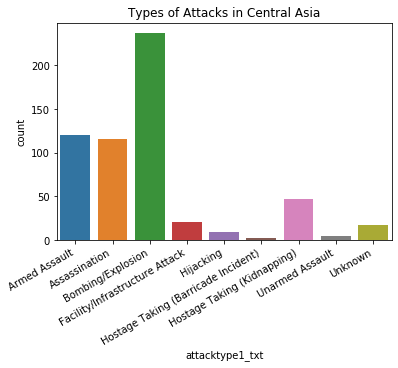

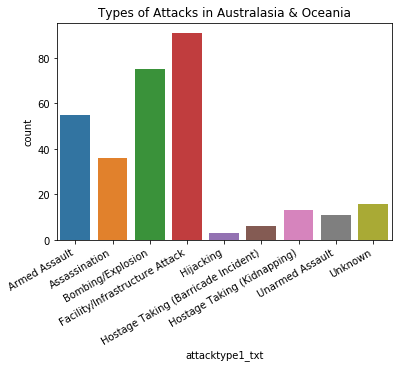

In [47]:


for i, region in enumerate(df.region_txt.value_counts().index):
    
    plt.figure(i)
    a = sns.countplot(df.sort_values(by = 'attacktype1_txt').loc[df.sort_values(by = 'attacktype1_txt').region_txt == region].attacktype1_txt)
    a.set_xticklabels(a.get_xticklabels(), rotation = 30, ha = 'right')
    a.set_title('Types of Attacks in {}'.format(region))






Clear trend among regions that Bombing/Explosion is the most common method for attackers. 
Armed assault is notably the most common in Central America/Carribean, and Sub-Saharan Africa  

<Figure size 1152x720 with 0 Axes>

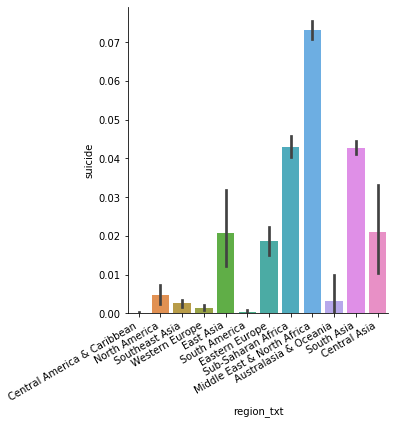

In [48]:
plt.figure(figsize = (16,10))
a = sns.catplot(data = df, kind = 'bar',  x = 'region_txt', y = 'suicide')
a.set_xticklabels( rotation = '30', ha = 'right')

prevalence of suicide attacks vary from region to region. 

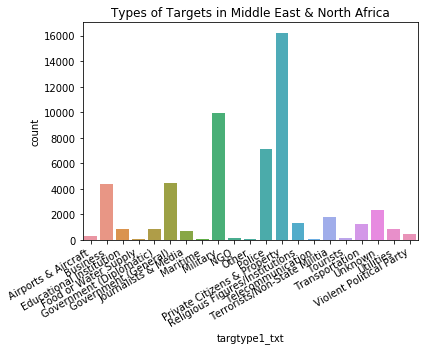

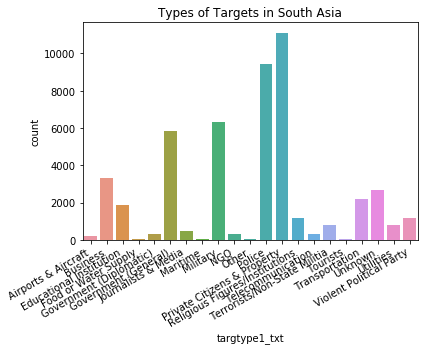

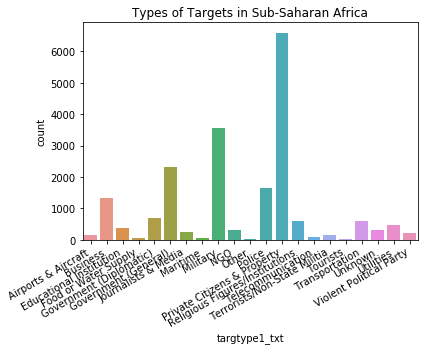

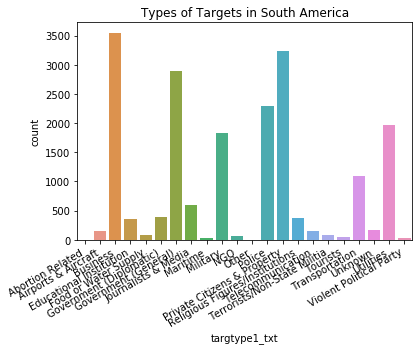

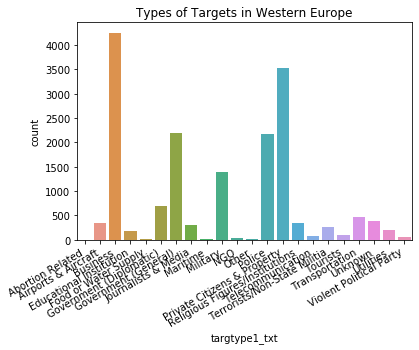

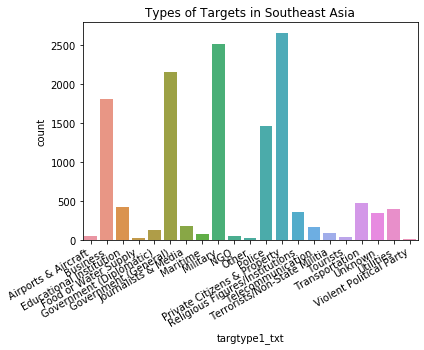

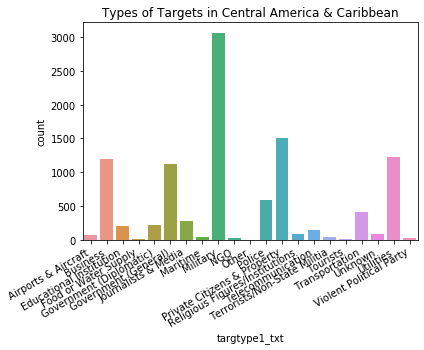

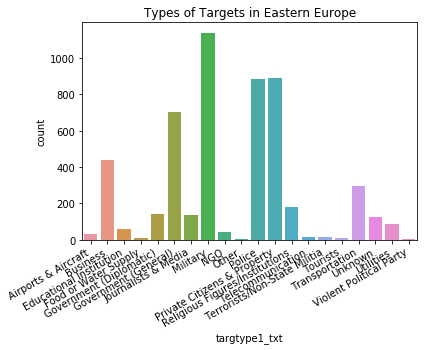

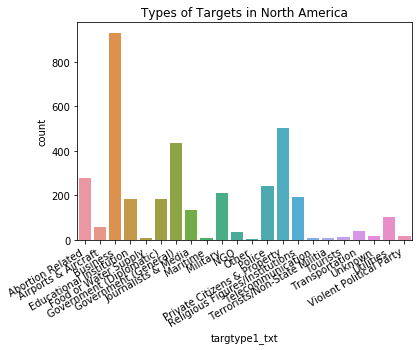

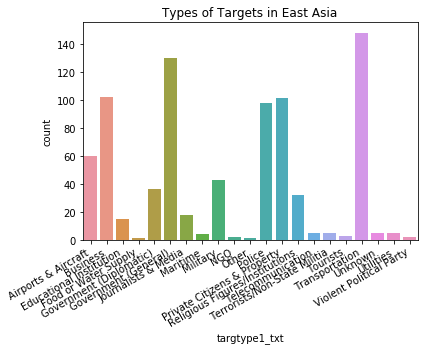

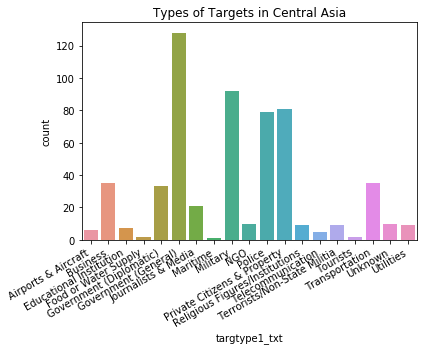

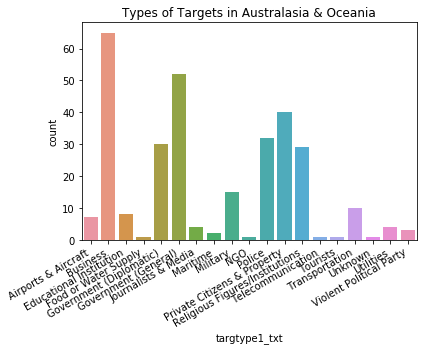

In [49]:
for i, region in enumerate(df.region_txt.value_counts().index):
    
    plt.figure(i)
    a = sns.countplot(df.sort_values(by = 'targtype1_txt').loc[df.sort_values(by = 'targtype1_txt').region_txt == region].targtype1_txt)
    a.set_xticklabels(a.get_xticklabels(), rotation = 30, ha = 'right')
    a.set_title('Types of Targets in {}'.format(region))

are attacks becoming more or less deadly?

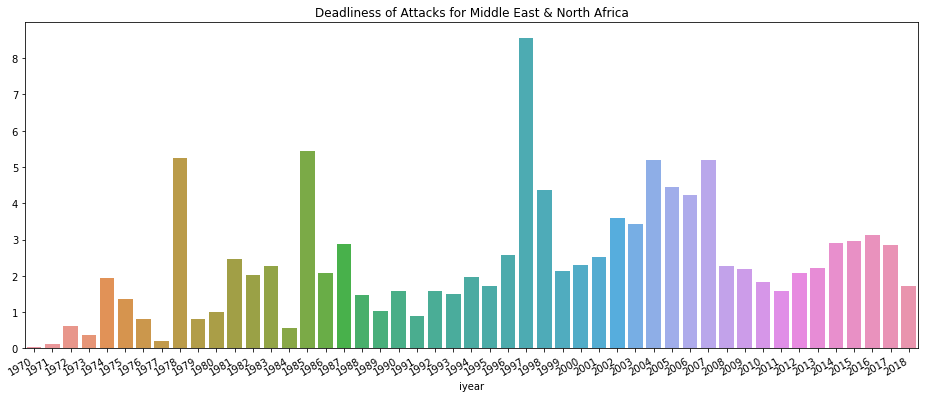

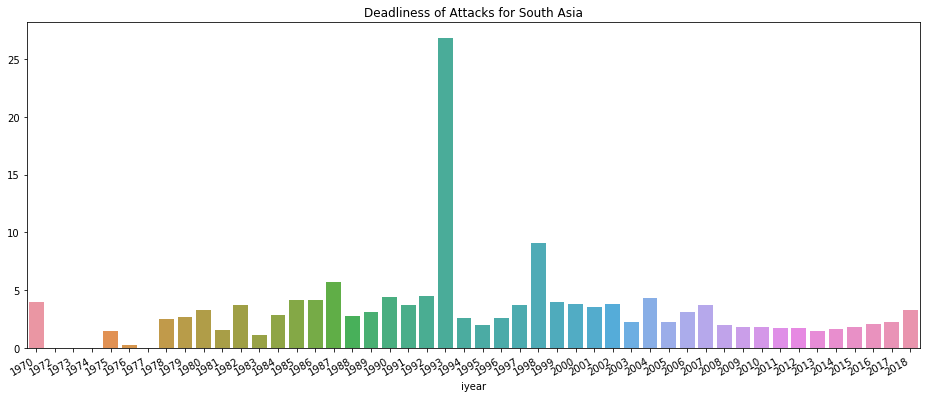

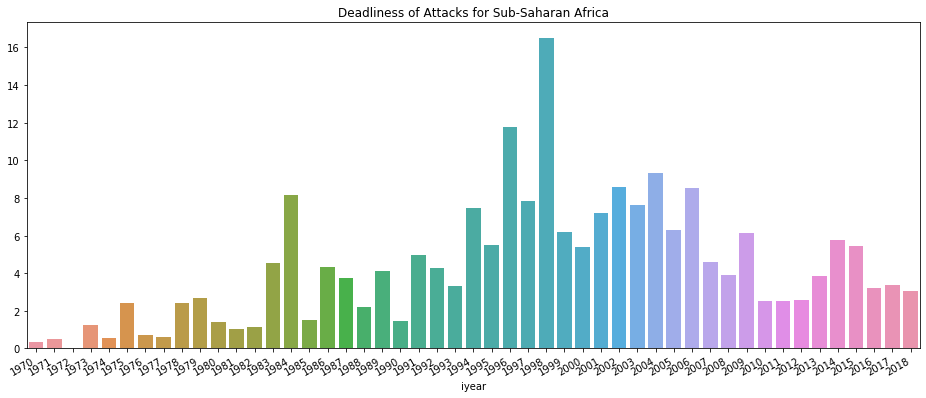

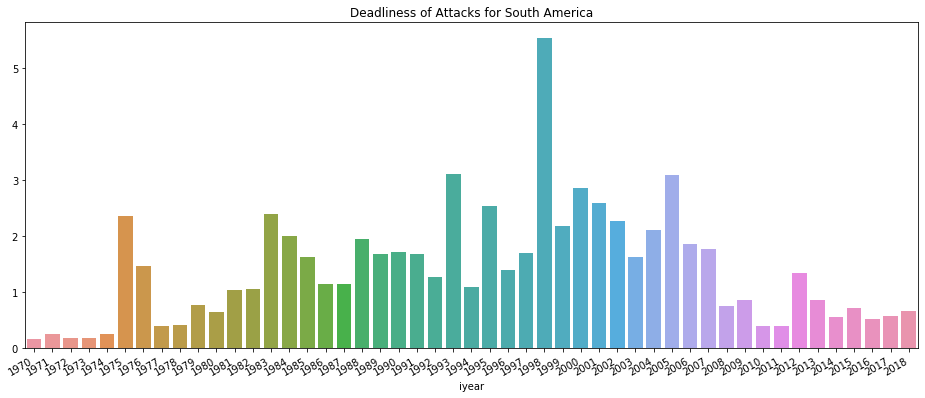

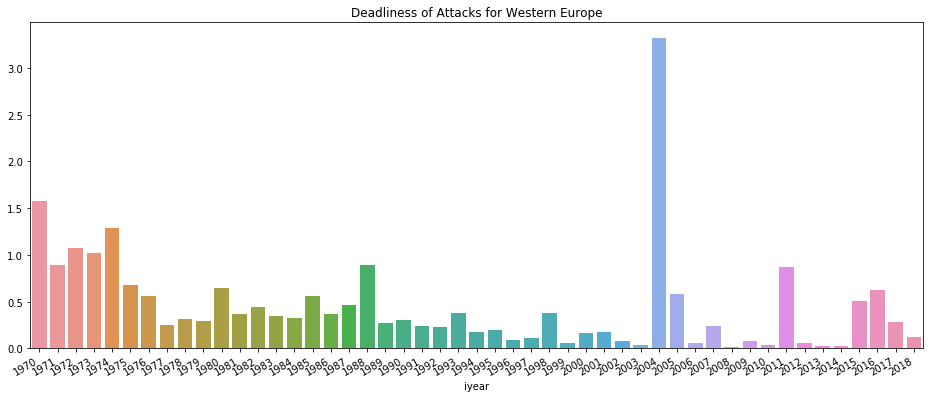

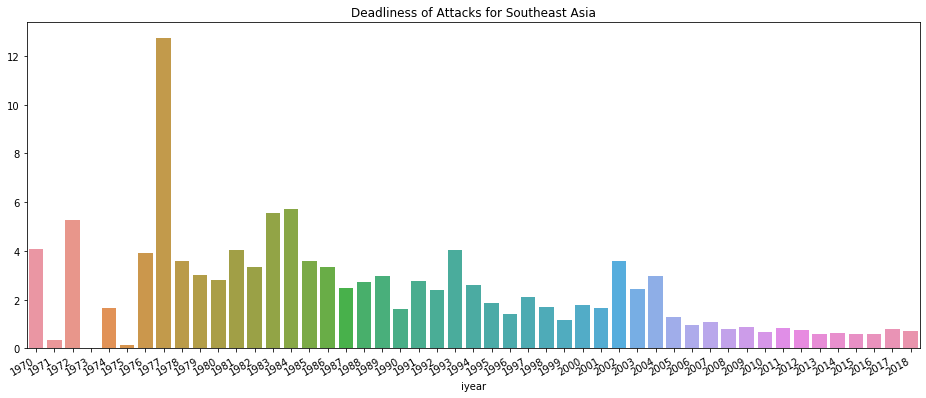

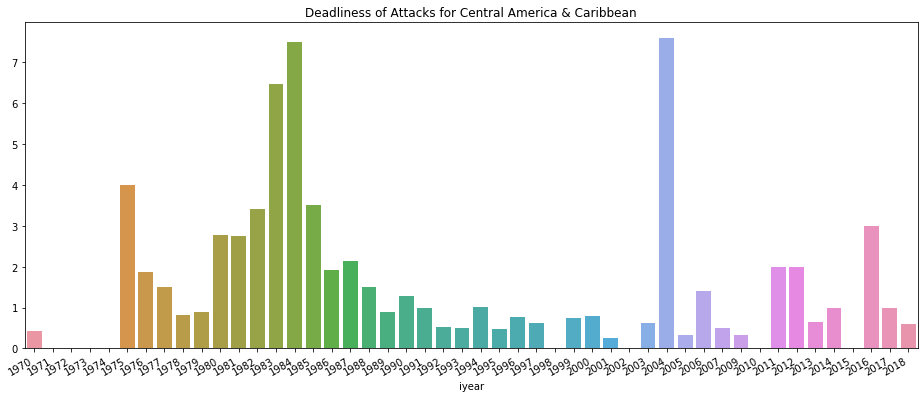

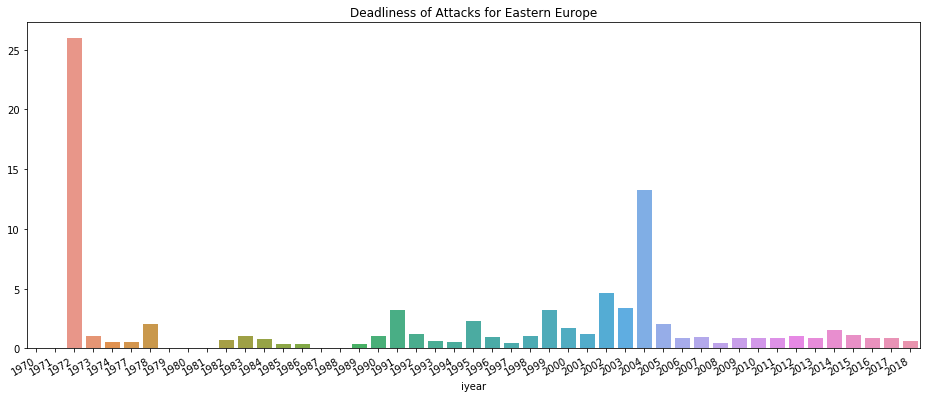

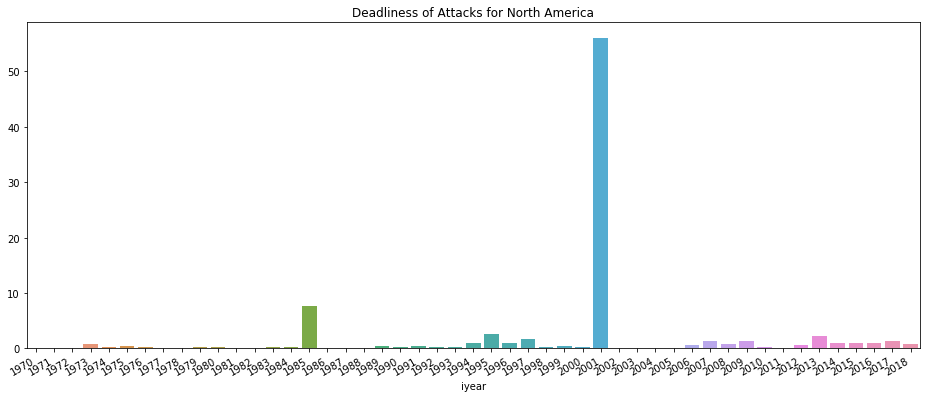

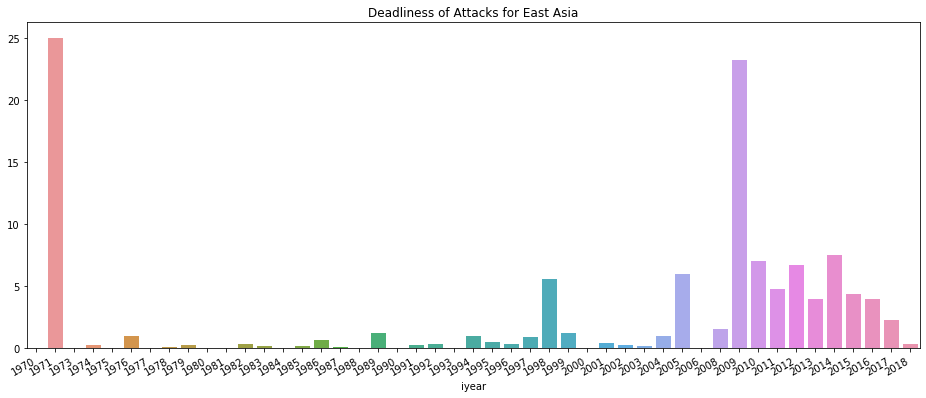

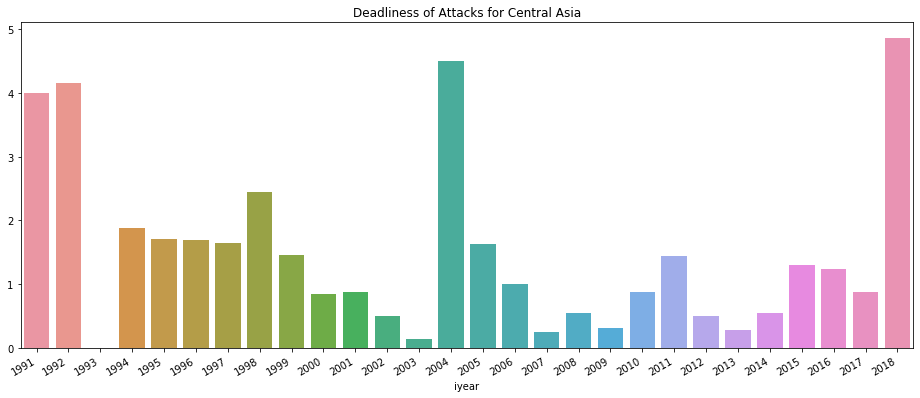

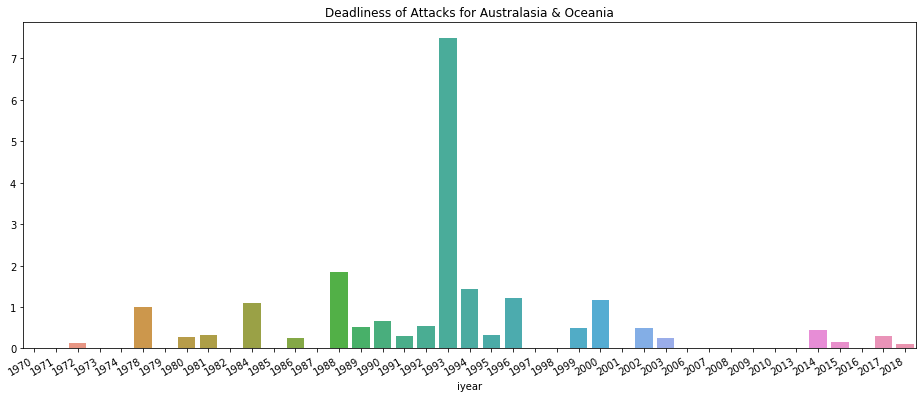

In [50]:
for i, region in enumerate(df.region_txt.value_counts().index):
    plt.figure(i, figsize = (16, 6))
    
    kills = df[df.region_txt == region].groupby(['iyear']).sum()['nkill']
    attacks = df[df.region_txt == region].groupby(['iyear']).count()['region_txt']
    
    a = sns.barplot(x = (kills/attacks).index, y = kills/attacks )
    a.set_xticklabels(labels =(kills/attacks).index,  rotation = '30', ha = 'right')
    a.set_title('Deadliness of Attacks for {}'.format(region))

Can see that this statistic is very prone to outliers. 
General trends are either static or decreasing

There seems to be a lot of overlap between regions, and perhaps having 12 different regions doesn't make the most sense. 
Going to group the data by year and country, then do some time-series clustering. 
Have a dataframe where each record is an attack, want one where each record is a country, second index of year.
Also have to choose which records to keep. 
for example, might not make sense to keep gname for clustering as very little overlap and huge number of categories.


Need to decide whether to include the categorical variables (e.g. type of attack, target, weapons etc) as a count or proportion of total number of attacks.

Leaning towards using counts, as the proportions of attacks vary wildly in countries where attacks are rare - will be lots of NaNs


To compare the nature of terrorism in each country, will want to standardise for population. GTD doesn't have a 'per capita' feature, so will use data from the world bank.
https://data.worldbank.org/indicator/SP.POP.TOTL

In [51]:
pop = pd.read_excel('Population.xlsx')
pop.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis = 1, inplace = True)
pop.drop(columns = (list(range(1960,1970)) + [2019,2020]), axis = 1, inplace = True)

In [52]:
pop_nat = pop['Country Name']
df_nat = sorted(df.country_txt.unique())

Some issues so far:

Not all the countries that exist at the end of the dataset (2019) existed at the start of the dataset - What should we do about this. 
Even among the countries that existed some aren't labeled the same in the population dataset - can fix this first. 

In [53]:
missing = []
for i in range(len(df_nat)):
    if df_nat[i] not in list(pop_nat):
        missing.append(df_nat[i])


In [54]:
#Annoyingly, the world bank's dataset on population has many countries listed under the same country name. 
#e.g. All the countries with 'Guinea' in their name are listed under 'Guinea', hong kong and macau are listed under 'China'
pop.loc[57, 'Country Name']='Dominican Republic'
pop.loc[85, 'Country Name'] ='Guinea-Bissau'
pop.loc[86, 'Country Name'] ='Equatorial Guinea'
pop.loc[187, 'Country Name'] ='Papua New Guinea'
pop.loc[172, 'Country Name']='Nigeria'
pop.loc[214, 'Country Name'] ='South Sudan'
pop.loc[94, 'Country Name'] ='Hong Kong'
pop.loc[144, 'Country Name'] ='Macau'



C:\Users\james\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\james\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\james\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://panda

In [55]:
name_convert = {'Brunei Darussalam':'Brunei','Bahamas, The': 'Bahamas','Bosnia and Herzegovina' : 'Bosnia-Herzegovina','Congo, Dem. Rep':'Democratic Republic of the Congo' ,'Egypt, Arab Rep.':'Egypt','Timor-Leste' :'East Timor', 'Congo, Dem. Rep.':'Democratic Republic of the Congo',
                'Cote d\'Ivoire':'Ivory Coast' , 'Kyrgyz Republic':'Kyrgyzstan', 'Lao PDR':'Laos', 'Korea, Dem. People’s Rep.':'North Korea', 'Congo, Rep.':'Republic of the Congo', 'Korea, Rep.' :'South Korea',
                'Eswatini':'Swaziland', 'Russian Federation': 'Russia', 'Gambia, The' : 'Gambia', 'Iran, Islamic Rep.' :'Iran', 'Yemen, Rep.':'Yemen', 'Venezuela, RB': 'Venezuela', 'Syrian Arab Republic':'Syria'}

for key in name_convert.keys():
    pop.loc[pop['Country Name'] == key, 'Country Name' ] = name_convert[key]

In [56]:
missing = []
pop_nat = pop['Country Name']
df_nat = sorted(df.country_txt.unique())
for i in range(len(df_nat)):
    if df_nat[i] not in list(pop_nat):
        missing.append(df_nat[i])
missing

['Czechoslovakia',
 'East Germany (GDR)',
 'Falkland Islands',
 'French Guiana',
 'Guadeloupe',
 'International',
 'Macedonia',
 'Martinique',
 'New Hebrides',
 'North Yemen',
 "People's Republic of the Congo",
 'Rhodesia',
 'Serbia-Montenegro',
 'South Vietnam',
 'South Yemen',
 'Soviet Union',
 'Taiwan',
 'Vatican City',
 'Wallis and Futuna',
 'West Bank and Gaza Strip',
 'West Germany (FRG)',
 'Western Sahara',
 'Yugoslavia',
 'Zaire']

now left with countries that don't exist anymore
need to decide if we can just rename them to be the country that they will end up being part of, in order to keep a singular time-series


Easy for countries like 'North Yemen', ends up being Yemen. 
For Yugoslavia etc, will need to find which of the constituent countries I can assign it to. 

In [57]:
for index in df.loc[df.country_txt == 'Czechoslovakia'].index:
    if df.loc[index,'city' ] == 'Bratislava':
        df.loc[index, 'country_txt'] = 'Slovak Republic'
    else:
        df.loc[index, 'country_txt'] = 'Czech Republic'
    

In [58]:
for index in df.loc[(df.country_txt == 'East Germany (GDR)') | (df.country_txt == 'West Germany (FRG)')].index:
    df.loc[index, 'country_txt'] = 'Germany'
    

In [59]:
for index in df.loc[(df.country_txt == 'North Yemen') | (df.country_txt == 'South Yemen')].index:
    df.loc[index, 'country_txt'] = 'Yemen'
for index in df.loc[(df.country_txt == 'North Vietnam') | (df.country_txt == 'South Vietnam')].index:
    df.loc[index, 'country_txt'] = 'Vietnam'

In [60]:
for index in df.loc[(df.country_txt == 'People\'s Republic of the Congo')].index:
    df.loc[index, 'country_txt'] = 'Republic of the Congo'
for index in df.loc[(df.country_txt == 'Zaire')].index:
    df.loc[index, 'country_txt'] = 'Democratic Republic of the Congo'

In [61]:
for index in df.loc[(df.country_txt == 'Serbia-Montenegro')].index:
    df.loc[index, 'country_txt'] = 'Serbia'

#manually checked, all serbia

In [62]:
for index in df.loc[(df.country_txt == 'Rhodesia')].index:
    df.loc[index, 'country_txt'] = 'Zimbabwe'

In [63]:
yugoslavia = ['Bosnia-Herzegovina', 'Croatia', 'Serbia', 'Montenegro', 'Slovenia', 'Macedonia', 'Kosovo' ]

In [64]:
#recombining Yugoslavia
for index in df.loc[df['country_txt'].isin(yugoslavia)].index:
    df.loc[index, 'country_txt'] = 'Yugoslavia'

In [65]:
missing = []
pop_nat = pop['Country Name']
df_nat = sorted(df.country_txt.unique())
for i in range(len(df_nat)):
    if df_nat[i] not in list(pop_nat):
        missing.append(df_nat[i])
missing

['Falkland Islands',
 'French Guiana',
 'Guadeloupe',
 'International',
 'Martinique',
 'New Hebrides',
 'Soviet Union',
 'Taiwan',
 'Vatican City',
 'Wallis and Futuna',
 'West Bank and Gaza Strip',
 'Western Sahara',
 'Yugoslavia']

In [66]:
#soviet union is an issue - recombine as well?

In [67]:
#serbia missing population values for first 20 years
mask = (pop['Country Name']== 'Serbia')  
pop.loc[mask] = pop.loc[mask].fillna(7500000)

In [68]:
#creating yugoslaviapop.loc[len(pop)] = yug_pop in population table 

yug_pop = ['Yugoslavia'] + list(pop.loc[pop['Country Name'].isin(yugoslavia), list(range(1970,2019))].sum(axis = 0))
pop.loc[len(pop)] = yug_pop

next issue is to clean up countries we don't need from the population 

In [69]:
missing = []
pop_nat = pop['Country Name']
df_nat = sorted(df.country_txt.unique())
for i in range(len(df_nat)):
    if df_nat[i] not in list(pop_nat):
        missing.append(df_nat[i])
missing

['Falkland Islands',
 'French Guiana',
 'Guadeloupe',
 'International',
 'Martinique',
 'New Hebrides',
 'Soviet Union',
 'Taiwan',
 'Vatican City',
 'Wallis and Futuna',
 'West Bank and Gaza Strip',
 'Western Sahara']

In [70]:
df.drop(df.loc[df.country_txt.isin(missing)].index, inplace = True)

In [71]:
missing = []
pop_nat = pop['Country Name']
df_nat = sorted(df.country_txt.unique())
for i in range(len(df_nat)):
    if df_nat[i] not in list(pop_nat):
        missing.append(df_nat[i])
missing

[]

The names countries now match the population dataset, and we only have countries left in the dataframe for which we know the populations.

Would like know the starting points for most of our time series. 

In [72]:
first_entry = []

for country in df.country_txt.unique():
    first_entry.append((country,int(df.loc[df.country_txt == country, 'iyear'].values[:1]) ))
    

majority of the data is before 1990, need to strike balance between lots of countries and as long time-series as possible  
uneven lenghths of time series will be an issue for certain clustering techniques  
another issue is that if there are 0 cases for a country in a year, there is no entry for that year.

Have no reason to believe that once the data has started to be gathered by the GTD, it stops for any country.   
Will therefore assume if there is no entry for a country after its first year in the dataset, there were no attacks that year  
and we can just add a zero entry for that year/country. 

In [180]:
to_keep = ['iyear', 'imonth', 'country_txt', 'attacktype1_txt','success', 'suicide', 'weaptype1_txt', 'targtype1_txt',  'nkill', 'nwound', 'nhostkid']
    
df2 = pd.get_dummies(df[to_keep], columns = ['imonth','attacktype1_txt', 'weaptype1_txt', 'targtype1_txt' ])
to_keep.remove('iyear')
to_keep.remove('country_txt')
#transform categorical variables, now need to group by to get a time-series dataset

aggregation = {}
for col in df2.columns:
    if col not in ['iyear', 'country_txt']:
        if col in ['success', 'suicide','nkill', 'nwound', 'nhostkid']:
            aggregation[col] = 'sum' #np.mean
        else:
            aggregation[col] = 'sum'

#went for counts of categorical variables - not concerned with the collinearity among features
#also, proportional method would have introduced a lot of variance and NaN values for countries with very few attacks per year.
df3 = df2.groupby(['country_txt', 'iyear']).agg(aggregation)

data is now in time series form, indexed by Country and Year. 

In [181]:
for country in df.country_txt.unique():
    start = df3.loc[(country)].index[0]
    for year in range(start+1, 2019):
        if year not in df3.loc[(country)].index:
            df3.loc[(country, year), :] = [0]*61
            df3.loc[(country)].sort_values('iyear', axis = 0, inplace = True)
            
#fill in years with no attacks

C:\Users\james\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [176]:
pop2 = pop.loc[pop['Country Name'].isin(df_nat)].reset_index(drop = True)
pop2.rename(columns = {'Country Name': 'country_txt'}, inplace = True)
#pop2.set_index('country_txt', inplace = True)


In [79]:
#only two countries with any null values 
pop2.isna().any(axis = 1)

0      False
1      False
2      False
3      False
4      False
       ...  
171    False
172    False
173    False
174    False
175    False
Length: 176, dtype: bool

In [165]:
#forward fill handfull of missing values
pop2[list(range(1970,2019))] =pop2[list(range(1970,2019))].fillna(axis = 1, method = 'ffill')
pop3 = pd.melt(pop2, id_vars = 'country_txt' ,value_vars = list(range(1970, 2019)), var_name = 'iyear', value_name = 'population')
pop3.set_index(['country_txt', 'iyear'], inplace = True)

In [182]:
for country in df_nat:
    for iyear in range(1970, 2019):
        try:
            df3.loc[country, iyear]/=(pop3.loc[country, iyear].values/1000000)
        except:
            continue
df3.sort_index(inplace = True)
#divide values by population/1mil gives us attacks per million of population

In [183]:
#add total attacks 
df3['total'] = df3[['imonth_1', 'imonth_2', 'imonth_3', 'imonth_4', 'imonth_5', 'imonth_6',
       'imonth_7', 'imonth_8', 'imonth_9', 'imonth_10', 'imonth_11',
       'imonth_12',]].sum(axis = 1)

In [186]:
#lots of variance year to year in the number of attacks want to see how the analysis is affected by using a 3 year moving average to smooth out the time dataset. 
df_mavg3 = df3.copy()
for column in df_mavg3.columns:
    for country in df_nat:
        df_mavg3.loc[country,column] = df_mavg3.loc[country,column].rolling(window = 3).mean().values

Text(0.5, 0, 'Year')

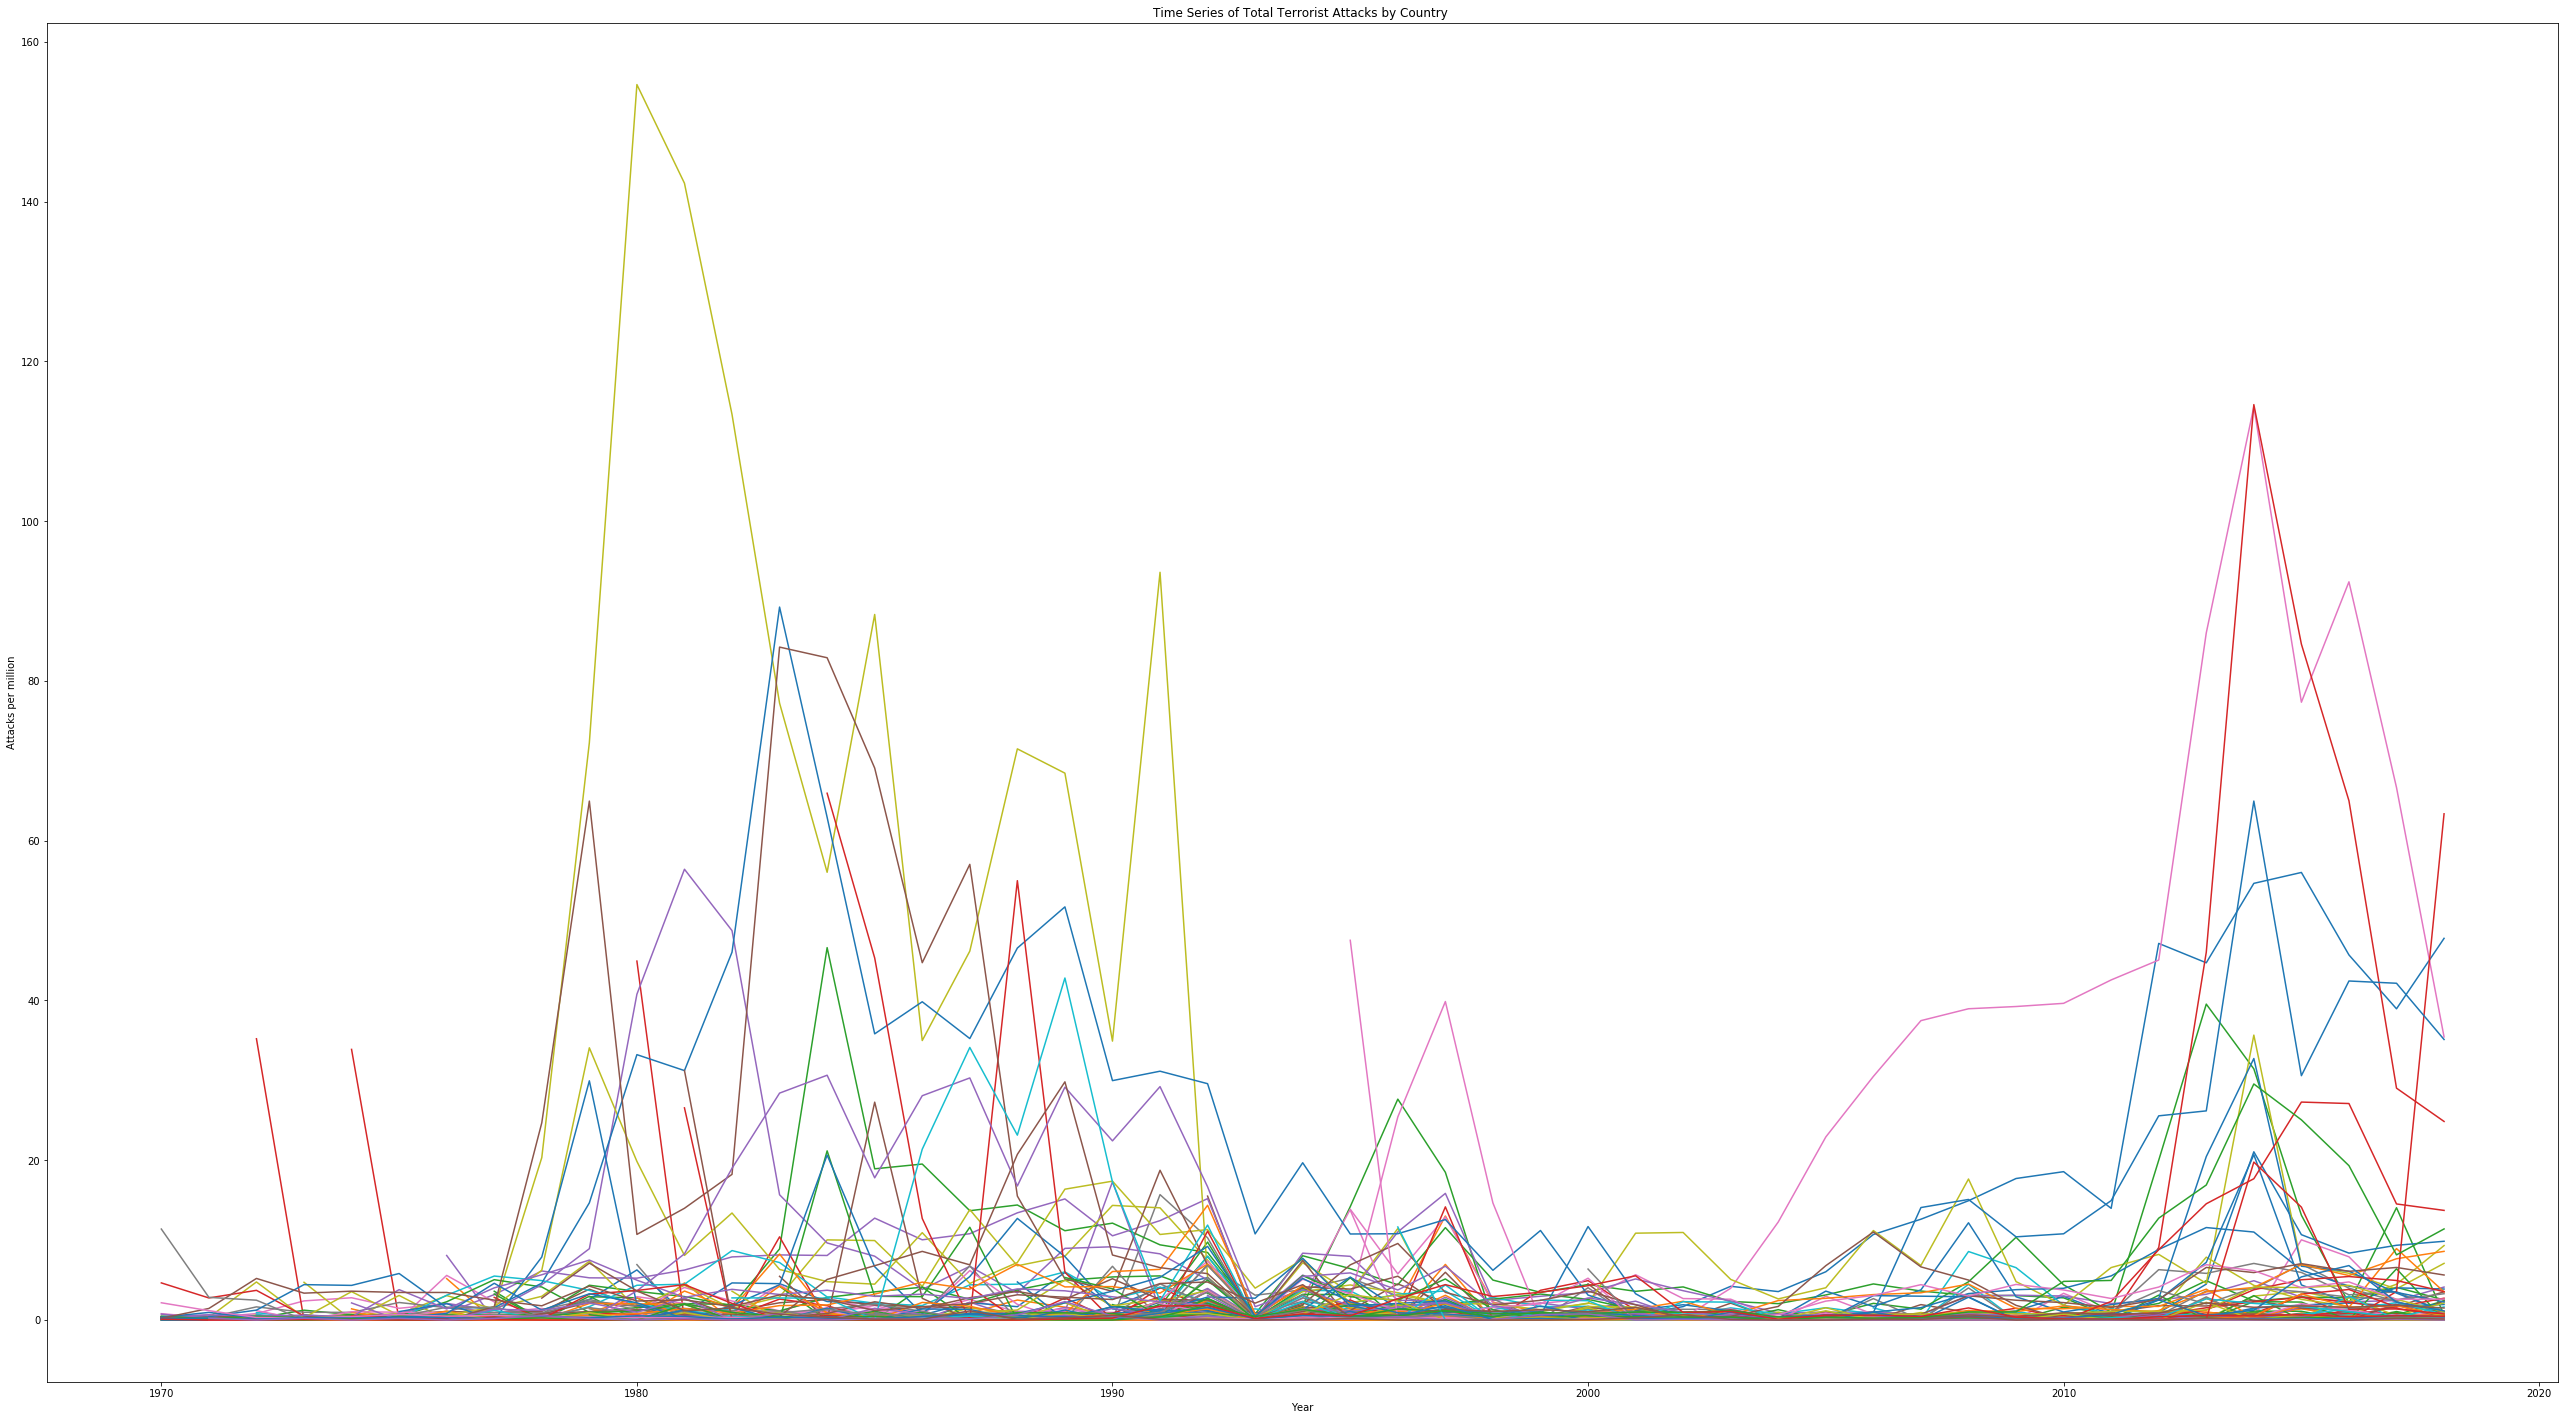

In [159]:

#TIME-SERIES HYPE
fig, axs = plt.subplots(1,figsize = (45, 25))

for country in df_nat:
    
    plt.plot(list(df3.loc[country].index), list(df3.loc[country]['total']))
axs.set_title('Time Series of Total Terrorist Attacks by Country ')
plt.ylabel('Attacks per million')
plt.xlabel('Year')


Text(0.5, 0, 'Year')

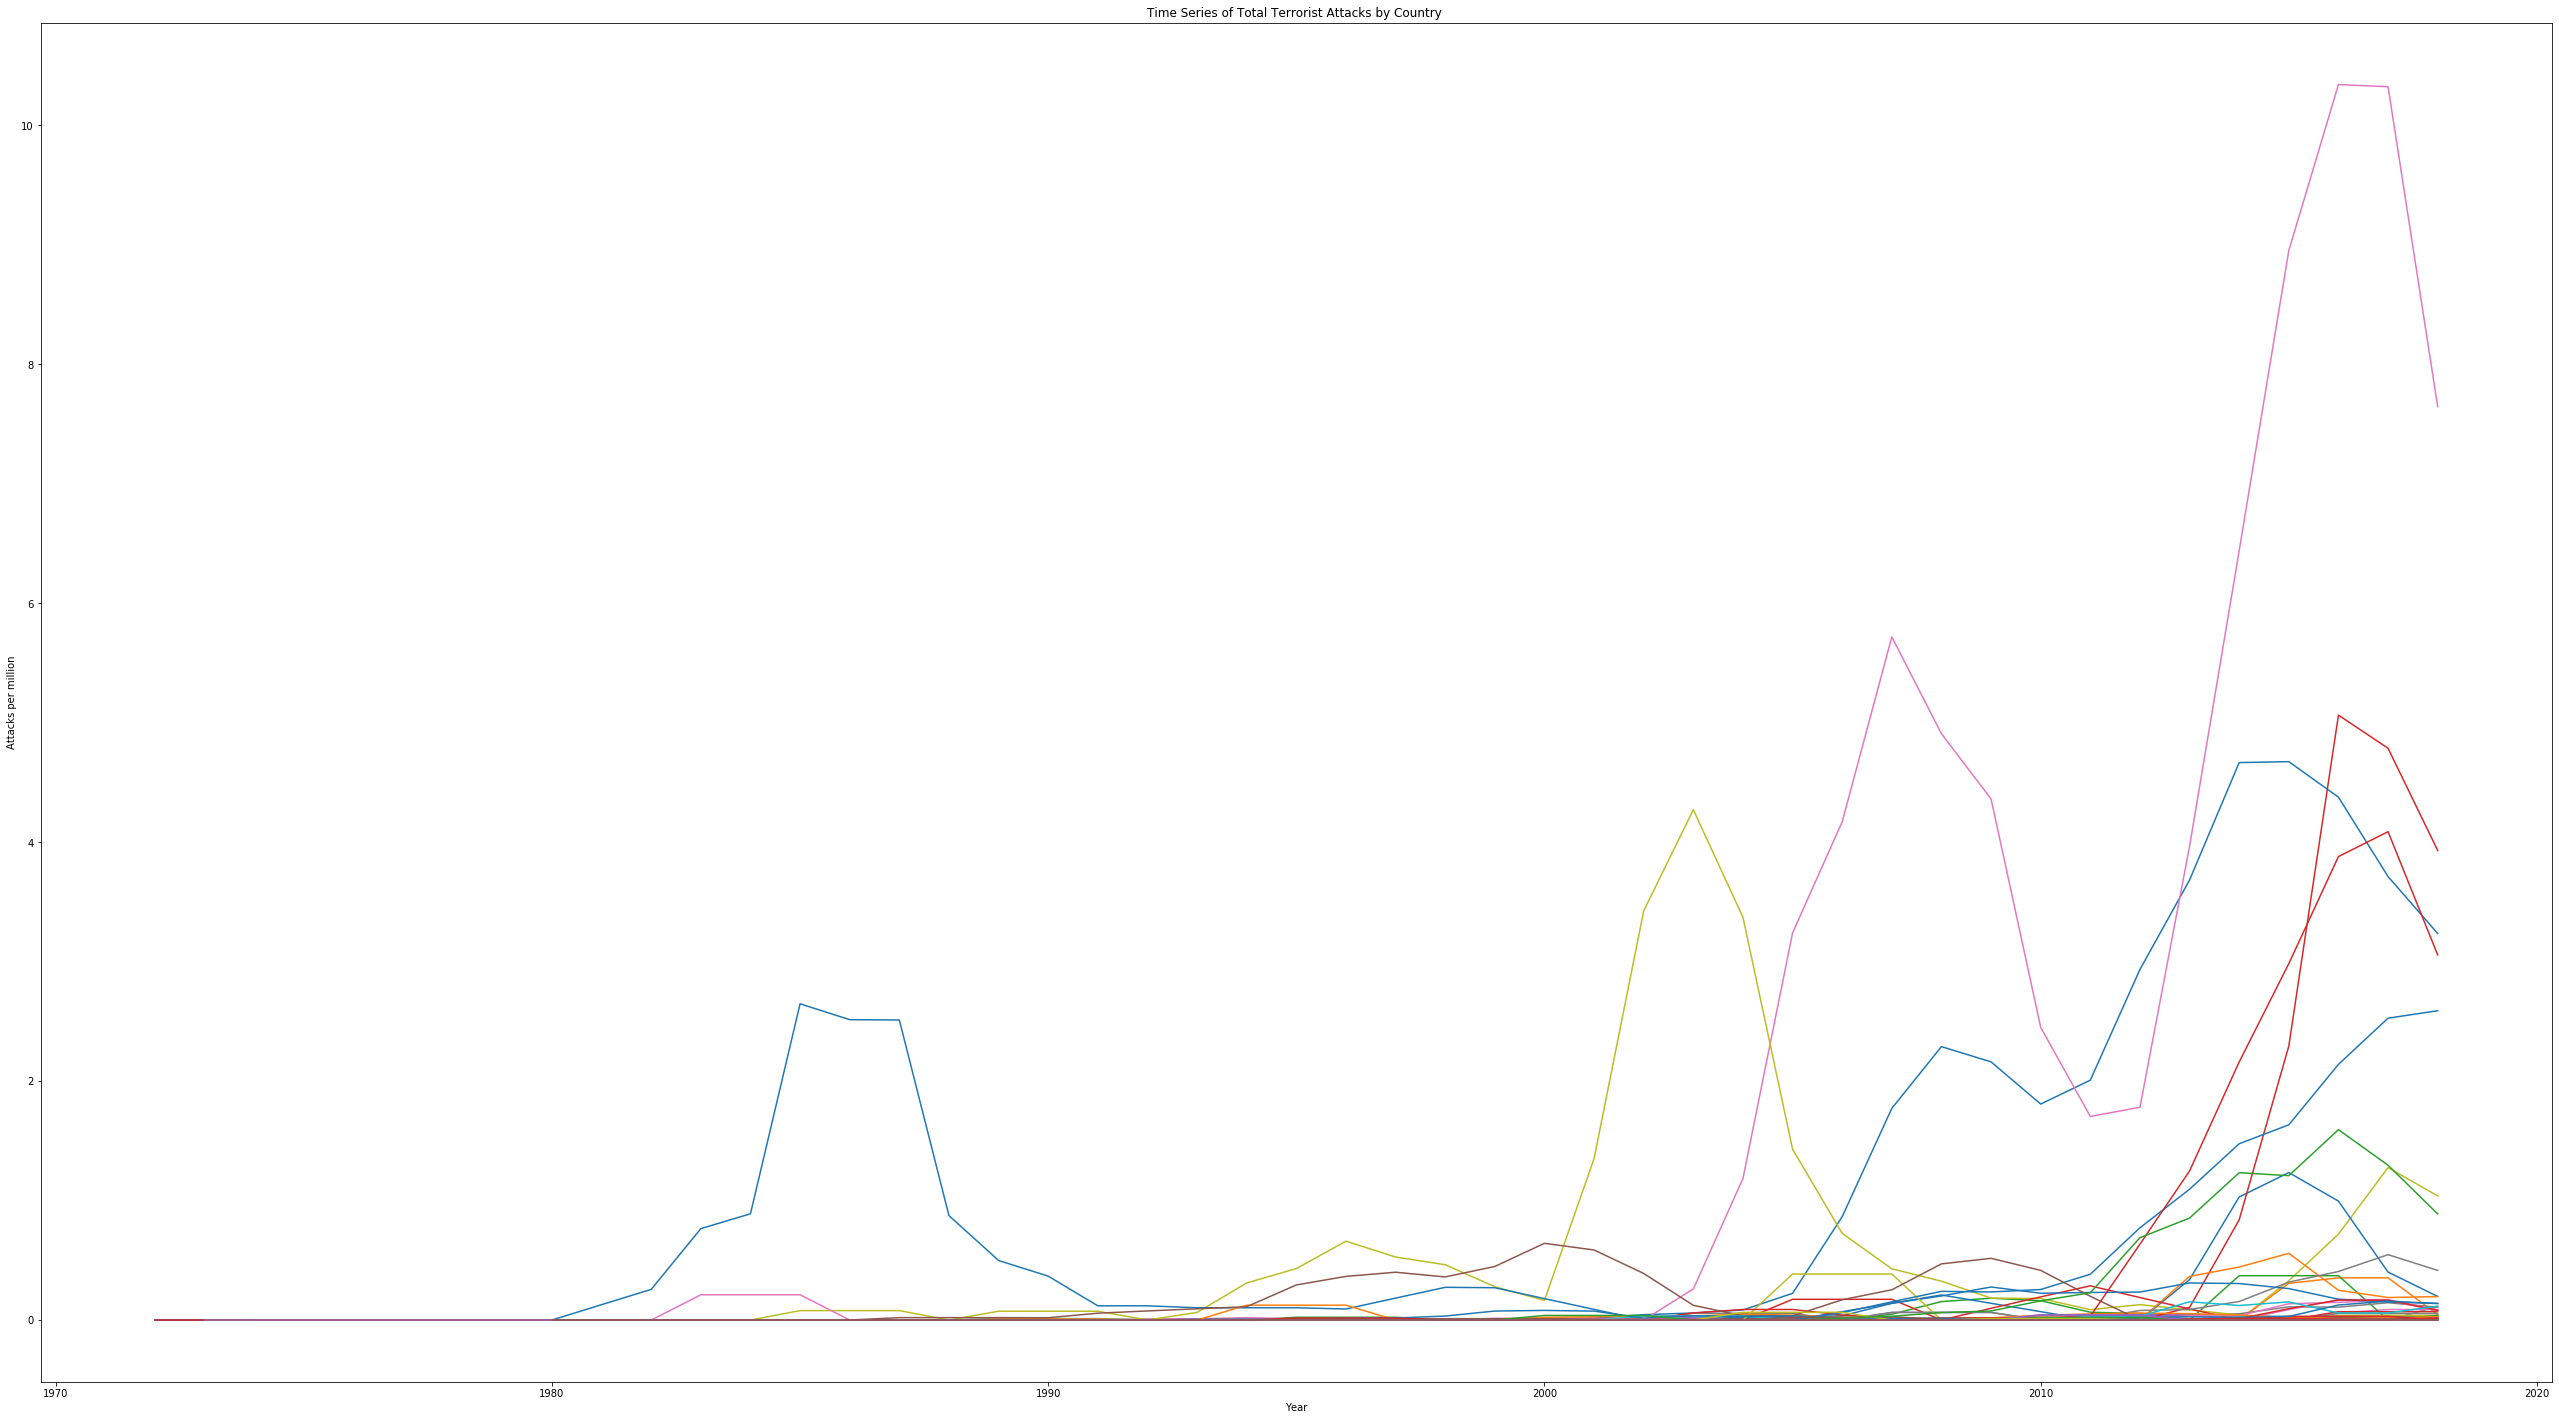

In [194]:

#TIME-SERIES HYPE
fig, axs = plt.subplots(1,figsize = (45, 25))

for country in df_nat:
    
    plt.plot(list(df_mavg3.loc[country].index), list(df_mavg3.loc[country]['suicide']))
axs.set_title('Time Series of Total Terrorist Attacks by Country ')
plt.ylabel('Attacks per million')
plt.xlabel('Year')

In [192]:

df3.to_csv('Ter_Time_Series.csv')
df_mavg3.to_csv('Mavg3_Time_Series.csv')

In [ ]:
df.to_csv('Raw_Preprocessed.csv')